In [27]:
import torch
from torch import nn
import torchvision.transforms
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision.transforms import Compose, RandomCrop, RandomHorizontalFlip, RandomGrayscale, ToTensor, ToPILImage

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
from collections import OrderedDict
from math import ceil
import time
import random
import glob

# Model

In [2]:
from Models import ResnetHasher, CustomHasher

### Visualization Tools

In [3]:
# Visualize Data
class ShowTensor():
    def __call__(self, tensor):
        npimg = tensor.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')
show_tensor = ShowTensor()
class ShowTriplet():
    def __call__(self, triplet, axes=True):
        npimgs = [ tensor.numpy() for tensor in triplet ] 
        fig, axs = plt.subplots(1,3, constrained_layout=True, figsize=(12,12))
        axs[0].imshow(np.transpose(npimgs[0], (1, 2, 0)), interpolation='nearest')
        axs[1].imshow(np.transpose(npimgs[1], (1, 2, 0)), interpolation='nearest')
        axs[2].imshow(np.transpose(npimgs[2], (1, 2, 0)), interpolation='nearest')
        axs[0].set_title("Anchor (A)")
        axs[1].set_title("Positive (P)")
        axs[2].set_title("Negative (N)")
        if not axes:
            axs[0].set_axis_off()
            axs[1].set_axis_off()
            axs[2].set_axis_off()
show_triplet = ShowTriplet()

In [4]:
# Visualize Model
from torchsummary import summary
def visualizeModel(model):
    summary(model, (3, 64, 64))
from Models import HasherBlock

#print([x for x in ResnetHasher().resnet.children()])
#ResnetHasher().visualize()

In [5]:
CustomHasher().visualize()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 32, 32]             336
         MaxPool2d-2           [-1, 12, 16, 16]               0
              ReLU-3           [-1, 12, 16, 16]               0
       BatchNorm2d-4           [-1, 12, 16, 16]              24
       HasherBlock-5           [-1, 12, 16, 16]               0
            Conv2d-6           [-1, 24, 16, 16]           2,616
         MaxPool2d-7             [-1, 24, 8, 8]               0
              ReLU-8             [-1, 24, 8, 8]               0
       BatchNorm2d-9             [-1, 24, 8, 8]              48
      HasherBlock-10             [-1, 24, 8, 8]               0
           Conv2d-11             [-1, 48, 8, 8]          10,416
        MaxPool2d-12             [-1, 48, 4, 4]               0
             ReLU-13             [-1, 48, 4, 4]               0
      BatchNorm2d-14             [-1, 4

# Load Training Data

### Image Augmentation/Transforms

In [6]:
class RandomR4:
    """Rotate by one of the given angles."""
    def __init__(self, angles):
        self.angles = angles
    def __call__(self, x):
        angle = random.choice(self.angles)
        return TF.rotate(x, angle)
class ToRGBTensor:
    def __init__(self):
        self.tt = ToTensor()
    def __call__(self, img):
        return self.tt(img.convert('RGB'))

In [7]:
transform = True
transforms = Compose([
    RandomCrop((64, 64), padding=4),
    RandomHorizontalFlip(.5),
    RandomR4((0, 90, 180, 270)),
    RandomGrayscale(0.3)
]) if transform else Compose([])

## DataGenerator

In [21]:
class TripletDataset(torch.utils.data.Dataset):    
    def __init__(self, directory, transforms, batch_size=64):
        self.transforms = transforms
        self.batch_size = batch_size
        
        self.file_list = glob.glob(f'{directory}/*.png')
        self.triplets_original = len(self.file_list) // 2
        
        self.tt = ToRGBTensor()
        
        print(f'Found {len(self.file_list)} images.')

    def __len__(self):
        return self.triplets_original

    # (A, P, N)
    def __getitem__(self, index):
        anchor = self.file_list[index]
        negative = self.file_list[self.triplets_original + index]
        
        A = Image.open(anchor)
        P = self.transforms(A)
        N = Image.open(negative)
        
        return (self.tt(A), self.tt(P), self.tt(N))
    
    def generate_batches(self):
        triplets_retrieved = 0
        while True:
            tr_after_yield = triplets_retrieved + self.batch_size
            
            triplet_tensors = [ self.__getitem__(x) for x in range(triplets_retrieved, min(tr_after_yield, len(self))) ]
            As=[];Ps=[];Ns=[]
            for triplet in triplet_tensors:
                As.append(triplet[0])
                Ps.append(triplet[1])
                Ns.append(triplet[2])
            combined = As + Ps + Ns
            
            tensor_stack = torch.stack(combined)
            yield tensor_stack
            triplets_retrieved = tr_after_yield
            
            if triplets_retrieved >= self.triplets_original:
                return
    def len_batches(self):
        return ceil(self.triplets_original / self.batch_size)

In [22]:
dataset = TripletDataset('Dataset', transforms)

Found 716506 images.


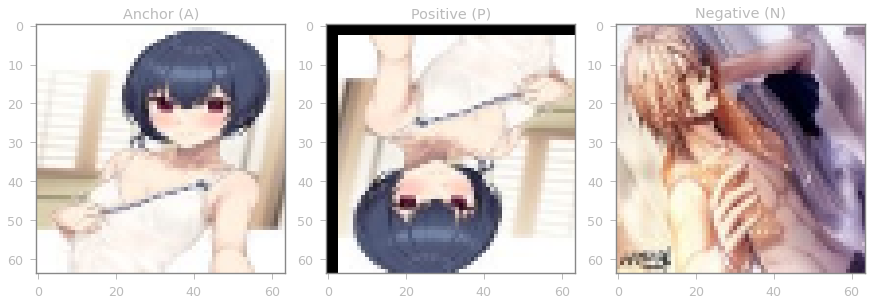

In [23]:
triplet = dataset[0]
show_triplet(triplet)

## Hyperparameters

## Triplet Loss:
$$L(\displaystyle A,\displaystyle P,\displaystyle N) = max\Big( d(f(\displaystyle A), f(\displaystyle P)) − d(f(\displaystyle A), f(\displaystyle N)) + margin, 0 \Big)$$

Where:
* ${\displaystyle A}$ is an anchor input, 
* ${\displaystyle P}$ is a positive input of the same class as ${\displaystyle A}$, 
* ${\displaystyle N}$ is a negative input of a different class from ${\displaystyle A}$, 
* ${\displaystyle \alpha }$  is a margin between positive and negative pairs, 
* ${\displaystyle \operatorname{f}}$ is an embedding on a metric space, and 
* ${\displaystyle \operatorname{d}}$ is a distance function on that space (In this case L1 or L2 norm, Manhattan and Euclidean distance respectively).

In [34]:
# Model
model = CustomHasher()

# Loss
norm_margin = .2
norm_type = 'Manhattan'
loss_fn = nn.TripletMarginLoss(margin=(norm_margin * (2**12)), p= 1 if norm_type=='Manhattan' else 2)

# Optimizer
opt = torch.optim.Adam(model.parameters(), lr=.02)

# Training Loop

In [35]:
for epoch in range(1):
    
    batch_num = 0
    batches = dataset.generate_batches()
    losses = []
    for batch in batches:
        # Batch is all As, then all Ps, then all Ns. There are always an equal number of each.
        # Start batch timer
        t0 = time.time()
        
        # Feed them all through at the same time to get batchnorm benefits
        model.zero_grad()
        out_tensors = model.forward(batch)
        A, P, N = out_tensors.split(len(batch) // 3)
        
        # Compute loss. Loss is broadcast across the batch
        loss = loss_fn(A, P, N)
        loss.backward()
        opt.step()
        t1 = time.time()
        
        
        batch_num += 1
        loss_num = loss.item()
        losses.append(loss_num)
        batch_time = round(t1-t0, 2)
        len_batches = dataset.len_batches()
        epoch_time_seconds = batch_time*len_batches
        epoch_time_minutes = round(epoch_time_seconds / 60, 2)
        print(f'Completed batch: {str(batch_num).rjust(4, " ")} of {len_batches} | Loss: {str(loss_num).rjust(5, " ")} | Time: {batch_time} (est. {epoch_time_minutes} min for epoch)')
        
    print(f'TODO epoch statistics')

Completed batch:    1 of 5598 | Loss: 1008.3026123046875 | Time: 0.34 (est. 31.72 min for epoch)
Completed batch:    2 of 5598 | Loss: 181.02574157714844 | Time: 0.34 (est. 31.72 min for epoch)
Completed batch:    3 of 5598 | Loss: 223.1036834716797 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch:    4 of 5598 | Loss: 193.2326202392578 | Time: 0.33 (est. 30.79 min for epoch)
Completed batch:    5 of 5598 | Loss: 142.98214721679688 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch:    6 of 5598 | Loss: 53.66539764404297 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch:    7 of 5598 | Loss: 50.29566955566406 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch:    8 of 5598 | Loss: 54.55316925048828 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch:    9 of 5598 | Loss: 18.998884201049805 | Time: 0.35 (est. 32.66 min for epoch)
Completed batch:   10 of 5598 | Loss: 95.85877990722656 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch:   11 of 5598 | Loss

Completed batch:   87 of 5598 | Loss: 38.47587585449219 | Time: 0.35 (est. 32.66 min for epoch)
Completed batch:   88 of 5598 | Loss: 71.37680053710938 | Time: 0.34 (est. 31.72 min for epoch)
Completed batch:   89 of 5598 | Loss: 88.46649932861328 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch:   90 of 5598 | Loss: 17.357717514038086 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch:   91 of 5598 | Loss: 19.0638370513916 | Time: 0.34 (est. 31.72 min for epoch)
Completed batch:   92 of 5598 | Loss: 67.55801391601562 | Time: 0.35 (est. 32.66 min for epoch)
Completed batch:   93 of 5598 | Loss: 51.65507125854492 | Time: 0.38 (est. 35.45 min for epoch)
Completed batch:   94 of 5598 | Loss: 50.19535827636719 | Time: 0.34 (est. 31.72 min for epoch)
Completed batch:   95 of 5598 | Loss: 53.526954650878906 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch:   96 of 5598 | Loss: 7.884880065917969 | Time: 0.35 (est. 32.66 min for epoch)
Completed batch:   97 of 5598 | Loss: 17

Completed batch:  173 of 5598 | Loss:   0.0 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch:  174 of 5598 | Loss: 75.04730987548828 | Time: 0.35 (est. 32.66 min for epoch)
Completed batch:  175 of 5598 | Loss: 13.499916076660156 | Time: 0.33 (est. 30.79 min for epoch)
Completed batch:  176 of 5598 | Loss: 34.47846984863281 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch:  177 of 5598 | Loss: 49.69282913208008 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch:  178 of 5598 | Loss: 33.26744842529297 | Time: 0.34 (est. 31.72 min for epoch)
Completed batch:  179 of 5598 | Loss: 107.3094482421875 | Time: 0.33 (est. 30.79 min for epoch)
Completed batch:  180 of 5598 | Loss: 24.998952865600586 | Time: 0.36 (est. 33.59 min for epoch)
Completed batch:  181 of 5598 | Loss: 19.510128021240234 | Time: 0.33 (est. 30.79 min for epoch)
Completed batch:  182 of 5598 | Loss: 38.02991485595703 | Time: 0.34 (est. 31.72 min for epoch)
Completed batch:  183 of 5598 | Loss: 87.74219512

Completed batch:  259 of 5598 | Loss: 25.056848526000977 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch:  260 of 5598 | Loss: 20.874448776245117 | Time: 0.33 (est. 30.79 min for epoch)
Completed batch:  261 of 5598 | Loss: 16.172348022460938 | Time: 0.33 (est. 30.79 min for epoch)
Completed batch:  262 of 5598 | Loss: 38.098304748535156 | Time: 0.34 (est. 31.72 min for epoch)
Completed batch:  263 of 5598 | Loss: 59.09541702270508 | Time: 0.34 (est. 31.72 min for epoch)
Completed batch:  264 of 5598 | Loss: 23.262632369995117 | Time: 0.34 (est. 31.72 min for epoch)
Completed batch:  265 of 5598 | Loss: 35.10078430175781 | Time: 0.34 (est. 31.72 min for epoch)
Completed batch:  266 of 5598 | Loss: 53.67673873901367 | Time: 0.35 (est. 32.66 min for epoch)
Completed batch:  267 of 5598 | Loss: 40.647705078125 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch:  268 of 5598 | Loss: 11.250051498413086 | Time: 0.34 (est. 31.72 min for epoch)
Completed batch:  269 of 5598 | Loss

Completed batch:  346 of 5598 | Loss: 13.82568359375 | Time: 0.35 (est. 32.66 min for epoch)
Completed batch:  347 of 5598 | Loss:   0.0 | Time: 0.33 (est. 30.79 min for epoch)
Completed batch:  348 of 5598 | Loss:   0.0 | Time: 0.33 (est. 30.79 min for epoch)
Completed batch:  349 of 5598 | Loss:   0.0 | Time: 0.35 (est. 32.66 min for epoch)
Completed batch:  350 of 5598 | Loss: 15.820866584777832 | Time: 0.35 (est. 32.66 min for epoch)
Completed batch:  351 of 5598 | Loss:   0.0 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch:  352 of 5598 | Loss:   0.0 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch:  353 of 5598 | Loss:   0.0 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch:  354 of 5598 | Loss: 125.85038757324219 | Time: 0.33 (est. 30.79 min for epoch)
Completed batch:  355 of 5598 | Loss: 19.822757720947266 | Time: 0.34 (est. 31.72 min for epoch)
Completed batch:  356 of 5598 | Loss: 1.437164306640625 | Time: 0.34 (est. 31.72 min for epoch)
Completed batch:

Completed batch:  434 of 5598 | Loss:   0.0 | Time: 0.39 (est. 36.39 min for epoch)
Completed batch:  435 of 5598 | Loss: 12.069284439086914 | Time: 0.34 (est. 31.72 min for epoch)
Completed batch:  436 of 5598 | Loss:   0.0 | Time: 0.38 (est. 35.45 min for epoch)
Completed batch:  437 of 5598 | Loss: 37.332550048828125 | Time: 0.39 (est. 36.39 min for epoch)
Completed batch:  438 of 5598 | Loss: 31.924930572509766 | Time: 0.38 (est. 35.45 min for epoch)
Completed batch:  439 of 5598 | Loss: 18.87934684753418 | Time: 0.39 (est. 36.39 min for epoch)
Completed batch:  440 of 5598 | Loss: 0.20795822143554688 | Time: 0.34 (est. 31.72 min for epoch)
Completed batch:  441 of 5598 | Loss: 29.379817962646484 | Time: 0.36 (est. 33.59 min for epoch)
Completed batch:  442 of 5598 | Loss: 2.600168228149414 | Time: 0.33 (est. 30.79 min for epoch)
Completed batch:  443 of 5598 | Loss: 6.017734527587891 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch:  444 of 5598 | Loss: 13.223918914794922 |

Completed batch:  522 of 5598 | Loss: 0.4056892395019531 | Time: 0.51 (est. 47.58 min for epoch)
Completed batch:  523 of 5598 | Loss: 6.734651565551758 | Time: 0.38 (est. 35.45 min for epoch)
Completed batch:  524 of 5598 | Loss: 3.309185028076172 | Time: 0.39 (est. 36.39 min for epoch)
Completed batch:  525 of 5598 | Loss: 19.301593780517578 | Time: 0.37 (est. 34.52 min for epoch)
Completed batch:  526 of 5598 | Loss: 3.440916061401367 | Time: 0.38 (est. 35.45 min for epoch)
Completed batch:  527 of 5598 | Loss: 24.686420440673828 | Time: 0.37 (est. 34.52 min for epoch)
Completed batch:  528 of 5598 | Loss: 41.10749435424805 | Time: 0.41 (est. 38.25 min for epoch)
Completed batch:  529 of 5598 | Loss: 5.950265884399414 | Time: 0.42 (est. 39.19 min for epoch)
Completed batch:  530 of 5598 | Loss: 26.592830657958984 | Time: 0.35 (est. 32.66 min for epoch)
Completed batch:  531 of 5598 | Loss: 6.64759635925293 | Time: 0.4 (est. 37.32 min for epoch)
Completed batch:  532 of 5598 | Loss: 

Completed batch:  611 of 5598 | Loss: 14.185535430908203 | Time: 0.34 (est. 31.72 min for epoch)
Completed batch:  612 of 5598 | Loss: 7.258317947387695 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch:  613 of 5598 | Loss:   0.0 | Time: 0.33 (est. 30.79 min for epoch)
Completed batch:  614 of 5598 | Loss:   0.0 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch:  615 of 5598 | Loss: 12.521476745605469 | Time: 0.33 (est. 30.79 min for epoch)
Completed batch:  616 of 5598 | Loss: 3.5873966217041016 | Time: 0.36 (est. 33.59 min for epoch)
Completed batch:  617 of 5598 | Loss:   0.0 | Time: 0.34 (est. 31.72 min for epoch)
Completed batch:  618 of 5598 | Loss: 42.20153045654297 | Time: 0.36 (est. 33.59 min for epoch)
Completed batch:  619 of 5598 | Loss: 39.41082000732422 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch:  620 of 5598 | Loss: 0.1775665283203125 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch:  621 of 5598 | Loss: 40.3868293762207 | Time: 0.36 (est

Completed batch:  699 of 5598 | Loss: 13.305486679077148 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch:  700 of 5598 | Loss:   0.0 | Time: 0.34 (est. 31.72 min for epoch)
Completed batch:  701 of 5598 | Loss: 21.951074600219727 | Time: 0.33 (est. 30.79 min for epoch)
Completed batch:  702 of 5598 | Loss: 63.639556884765625 | Time: 0.33 (est. 30.79 min for epoch)
Completed batch:  703 of 5598 | Loss: 26.23027801513672 | Time: 0.33 (est. 30.79 min for epoch)
Completed batch:  704 of 5598 | Loss: 52.72608184814453 | Time: 0.35 (est. 32.66 min for epoch)
Completed batch:  705 of 5598 | Loss: 17.89057159423828 | Time: 0.33 (est. 30.79 min for epoch)
Completed batch:  706 of 5598 | Loss: 23.598949432373047 | Time: 0.34 (est. 31.72 min for epoch)
Completed batch:  707 of 5598 | Loss: 28.1590576171875 | Time: 0.33 (est. 30.79 min for epoch)
Completed batch:  708 of 5598 | Loss: 6.703920364379883 | Time: 0.33 (est. 30.79 min for epoch)
Completed batch:  709 of 5598 | Loss: 14.45755004

Completed batch:  787 of 5598 | Loss:   0.0 | Time: 0.35 (est. 32.66 min for epoch)
Completed batch:  788 of 5598 | Loss: 21.905616760253906 | Time: 0.33 (est. 30.79 min for epoch)
Completed batch:  789 of 5598 | Loss: 19.0264892578125 | Time: 0.33 (est. 30.79 min for epoch)
Completed batch:  790 of 5598 | Loss: 28.188907623291016 | Time: 0.34 (est. 31.72 min for epoch)
Completed batch:  791 of 5598 | Loss: 11.115482330322266 | Time: 0.33 (est. 30.79 min for epoch)
Completed batch:  792 of 5598 | Loss: 5.4644670486450195 | Time: 0.33 (est. 30.79 min for epoch)
Completed batch:  793 of 5598 | Loss:   0.0 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch:  794 of 5598 | Loss: 11.31473159790039 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch:  795 of 5598 | Loss: 15.88082218170166 | Time: 0.34 (est. 31.72 min for epoch)
Completed batch:  796 of 5598 | Loss: 9.135051727294922 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch:  797 of 5598 | Loss:   0.0 | Time: 0.32 (est

Completed batch:  875 of 5598 | Loss: 0.6632709503173828 | Time: 0.35 (est. 32.66 min for epoch)
Completed batch:  876 of 5598 | Loss: 10.913793563842773 | Time: 0.35 (est. 32.66 min for epoch)
Completed batch:  877 of 5598 | Loss: 7.438007354736328 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch:  878 of 5598 | Loss: 2.9187545776367188 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch:  879 of 5598 | Loss:   0.0 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch:  880 of 5598 | Loss:   0.0 | Time: 0.34 (est. 31.72 min for epoch)
Completed batch:  881 of 5598 | Loss: 1.8006820678710938 | Time: 0.34 (est. 31.72 min for epoch)
Completed batch:  882 of 5598 | Loss:   0.0 | Time: 0.33 (est. 30.79 min for epoch)
Completed batch:  883 of 5598 | Loss:   0.0 | Time: 0.36 (est. 33.59 min for epoch)
Completed batch:  884 of 5598 | Loss:   0.0 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch:  885 of 5598 | Loss:   0.0 | Time: 0.35 (est. 32.66 min for epoch)
Completed bat

Completed batch:  964 of 5598 | Loss: 5.562953948974609 | Time: 0.35 (est. 32.66 min for epoch)
Completed batch:  965 of 5598 | Loss: 35.211395263671875 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch:  966 of 5598 | Loss: 11.06527042388916 | Time: 0.35 (est. 32.66 min for epoch)
Completed batch:  967 of 5598 | Loss: 20.327842712402344 | Time: 0.34 (est. 31.72 min for epoch)
Completed batch:  968 of 5598 | Loss: 42.30162048339844 | Time: 0.36 (est. 33.59 min for epoch)
Completed batch:  969 of 5598 | Loss:   0.0 | Time: 0.38 (est. 35.45 min for epoch)
Completed batch:  970 of 5598 | Loss: 19.356008529663086 | Time: 0.34 (est. 31.72 min for epoch)
Completed batch:  971 of 5598 | Loss: 1.3983545303344727 | Time: 0.33 (est. 30.79 min for epoch)
Completed batch:  972 of 5598 | Loss: 1.8404121398925781 | Time: 0.34 (est. 31.72 min for epoch)
Completed batch:  973 of 5598 | Loss: 56.3756217956543 | Time: 0.33 (est. 30.79 min for epoch)
Completed batch:  974 of 5598 | Loss: 21.6590576

Completed batch: 1052 of 5598 | Loss: 45.02962112426758 | Time: 0.33 (est. 30.79 min for epoch)
Completed batch: 1053 of 5598 | Loss: 77.011962890625 | Time: 0.33 (est. 30.79 min for epoch)
Completed batch: 1054 of 5598 | Loss: 22.144790649414062 | Time: 0.33 (est. 30.79 min for epoch)
Completed batch: 1055 of 5598 | Loss: 8.51179313659668 | Time: 0.34 (est. 31.72 min for epoch)
Completed batch: 1056 of 5598 | Loss: 28.57059097290039 | Time: 0.48 (est. 44.78 min for epoch)
Completed batch: 1057 of 5598 | Loss: 16.651988983154297 | Time: 0.41 (est. 38.25 min for epoch)
Completed batch: 1058 of 5598 | Loss:   0.0 | Time: 0.51 (est. 47.58 min for epoch)
Completed batch: 1059 of 5598 | Loss: 3.4607677459716797 | Time: 0.38 (est. 35.45 min for epoch)
Completed batch: 1060 of 5598 | Loss: 14.35310173034668 | Time: 0.41 (est. 38.25 min for epoch)
Completed batch: 1061 of 5598 | Loss: 12.937614440917969 | Time: 0.39 (est. 36.39 min for epoch)
Completed batch: 1062 of 5598 | Loss: 18.8358154296

Completed batch: 1140 of 5598 | Loss: 10.136478424072266 | Time: 0.33 (est. 30.79 min for epoch)
Completed batch: 1141 of 5598 | Loss:   0.0 | Time: 0.34 (est. 31.72 min for epoch)
Completed batch: 1142 of 5598 | Loss: 46.903053283691406 | Time: 0.34 (est. 31.72 min for epoch)
Completed batch: 1143 of 5598 | Loss:   0.0 | Time: 0.33 (est. 30.79 min for epoch)
Completed batch: 1144 of 5598 | Loss: 2.575031280517578 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 1145 of 5598 | Loss: 11.149662971496582 | Time: 0.34 (est. 31.72 min for epoch)
Completed batch: 1146 of 5598 | Loss: 9.843266487121582 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch: 1147 of 5598 | Loss: 16.74905776977539 | Time: 0.36 (est. 33.59 min for epoch)
Completed batch: 1148 of 5598 | Loss:   0.0 | Time: 0.29 (est. 27.06 min for epoch)
Completed batch: 1149 of 5598 | Loss: 8.207298278808594 | Time: 0.36 (est. 33.59 min for epoch)
Completed batch: 1150 of 5598 | Loss: 15.435333251953125 | Time: 0.32 (es

Completed batch: 1229 of 5598 | Loss: 8.92134952545166 | Time: 0.33 (est. 30.79 min for epoch)
Completed batch: 1230 of 5598 | Loss: 16.151145935058594 | Time: 0.34 (est. 31.72 min for epoch)
Completed batch: 1231 of 5598 | Loss: 25.625810623168945 | Time: 0.34 (est. 31.72 min for epoch)
Completed batch: 1232 of 5598 | Loss: 19.993818283081055 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch: 1233 of 5598 | Loss: 50.96788024902344 | Time: 0.34 (est. 31.72 min for epoch)
Completed batch: 1234 of 5598 | Loss:   0.0 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch: 1235 of 5598 | Loss: 21.427642822265625 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch: 1236 of 5598 | Loss: 4.489921569824219 | Time: 0.34 (est. 31.72 min for epoch)
Completed batch: 1237 of 5598 | Loss:   0.0 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch: 1238 of 5598 | Loss:   0.0 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch: 1239 of 5598 | Loss:   0.0 | Time: 0.34 (est. 31.72 min 

Completed batch: 1320 of 5598 | Loss:   0.0 | Time: 0.33 (est. 30.79 min for epoch)
Completed batch: 1321 of 5598 | Loss: 22.890281677246094 | Time: 0.34 (est. 31.72 min for epoch)
Completed batch: 1322 of 5598 | Loss: 12.537084579467773 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 1323 of 5598 | Loss:   0.0 | Time: 0.33 (est. 30.79 min for epoch)
Completed batch: 1324 of 5598 | Loss: 42.174171447753906 | Time: 0.33 (est. 30.79 min for epoch)
Completed batch: 1325 of 5598 | Loss: 1.1094245910644531 | Time: 0.35 (est. 32.66 min for epoch)
Completed batch: 1326 of 5598 | Loss: 5.491889953613281 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 1327 of 5598 | Loss: 3.3413009643554688 | Time: 0.29 (est. 27.06 min for epoch)
Completed batch: 1328 of 5598 | Loss:   0.0 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 1329 of 5598 | Loss:   0.0 | Time: 0.29 (est. 27.06 min for epoch)
Completed batch: 1330 of 5598 | Loss: 11.195743560791016 | Time: 0.31 (est. 28.92 mi

Completed batch: 1410 of 5598 | Loss: 11.525213241577148 | Time: 0.33 (est. 30.79 min for epoch)
Completed batch: 1411 of 5598 | Loss:   0.0 | Time: 0.35 (est. 32.66 min for epoch)
Completed batch: 1412 of 5598 | Loss: 31.459253311157227 | Time: 0.29 (est. 27.06 min for epoch)
Completed batch: 1413 of 5598 | Loss: 13.641338348388672 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch: 1414 of 5598 | Loss:   0.0 | Time: 0.27 (est. 25.19 min for epoch)
Completed batch: 1415 of 5598 | Loss: 4.274106025695801 | Time: 0.27 (est. 25.19 min for epoch)
Completed batch: 1416 of 5598 | Loss:   0.0 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 1417 of 5598 | Loss: 53.377994537353516 | Time: 0.29 (est. 27.06 min for epoch)
Completed batch: 1418 of 5598 | Loss: 14.999137878417969 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch: 1419 of 5598 | Loss:   0.0 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch: 1420 of 5598 | Loss: 5.052755355834961 | Time: 0.29 (est. 27.06 mi

Completed batch: 1500 of 5598 | Loss: 5.368490219116211 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 1501 of 5598 | Loss: 20.482093811035156 | Time: 0.29 (est. 27.06 min for epoch)
Completed batch: 1502 of 5598 | Loss: 10.961236953735352 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch: 1503 of 5598 | Loss: 40.58727264404297 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 1504 of 5598 | Loss:   0.0 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 1505 of 5598 | Loss: 13.16622543334961 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 1506 of 5598 | Loss: 6.7574920654296875 | Time: 0.28 (est. 26.12 min for epoch)
Completed batch: 1507 of 5598 | Loss:   0.0 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 1508 of 5598 | Loss: 41.365318298339844 | Time: 0.29 (est. 27.06 min for epoch)
Completed batch: 1509 of 5598 | Loss: 30.59247589111328 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 1510 of 5598 | Loss:   0.0 | Time: 0.3 (est. 

Completed batch: 1589 of 5598 | Loss: 26.852476119995117 | Time: 0.29 (est. 27.06 min for epoch)
Completed batch: 1590 of 5598 | Loss: 2.894280433654785 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 1591 of 5598 | Loss:   0.0 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 1592 of 5598 | Loss: 1.1423797607421875 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 1593 of 5598 | Loss:   0.0 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 1594 of 5598 | Loss:   0.0 | Time: 0.29 (est. 27.06 min for epoch)
Completed batch: 1595 of 5598 | Loss: 7.367637634277344 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch: 1596 of 5598 | Loss: 1.1513710021972656 | Time: 0.27 (est. 25.19 min for epoch)
Completed batch: 1597 of 5598 | Loss: 2.9837818145751953 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 1598 of 5598 | Loss: 21.84359359741211 | Time: 0.33 (est. 30.79 min for epoch)
Completed batch: 1599 of 5598 | Loss:   0.0 | Time: 0.32 (est. 29.86 min f

Completed batch: 1679 of 5598 | Loss: 4.104178428649902 | Time: 0.29 (est. 27.06 min for epoch)
Completed batch: 1680 of 5598 | Loss: 23.12753677368164 | Time: 0.33 (est. 30.79 min for epoch)
Completed batch: 1681 of 5598 | Loss: 37.59744644165039 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 1682 of 5598 | Loss:   0.0 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 1683 of 5598 | Loss:   0.0 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch: 1684 of 5598 | Loss:   0.0 | Time: 0.28 (est. 26.12 min for epoch)
Completed batch: 1685 of 5598 | Loss: 34.07275390625 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch: 1686 of 5598 | Loss: 54.252357482910156 | Time: 0.27 (est. 25.19 min for epoch)
Completed batch: 1687 of 5598 | Loss: 18.789955139160156 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch: 1688 of 5598 | Loss: 1.1148357391357422 | Time: 0.27 (est. 25.19 min for epoch)
Completed batch: 1689 of 5598 | Loss: 14.21163272857666 | Time: 0.29 (est. 27

Completed batch: 1768 of 5598 | Loss: 2.8890724182128906 | Time: 0.33 (est. 30.79 min for epoch)
Completed batch: 1769 of 5598 | Loss: 8.68376350402832 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 1770 of 5598 | Loss: 12.439458847045898 | Time: 0.33 (est. 30.79 min for epoch)
Completed batch: 1771 of 5598 | Loss: 5.378053665161133 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 1772 of 5598 | Loss:   0.0 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 1773 of 5598 | Loss: 8.289188385009766 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 1774 of 5598 | Loss: 6.5491790771484375 | Time: 0.33 (est. 30.79 min for epoch)
Completed batch: 1775 of 5598 | Loss: 0.5953941345214844 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 1776 of 5598 | Loss:   0.0 | Time: 0.29 (est. 27.06 min for epoch)
Completed batch: 1777 of 5598 | Loss: 24.752559661865234 | Time: 0.43 (est. 40.12 min for epoch)
Completed batch: 1778 of 5598 | Loss: 13.827152252197266 | Tim

Completed batch: 1857 of 5598 | Loss: 51.20352554321289 | Time: 0.29 (est. 27.06 min for epoch)
Completed batch: 1858 of 5598 | Loss: 37.285362243652344 | Time: 0.33 (est. 30.79 min for epoch)
Completed batch: 1859 of 5598 | Loss: 29.396869659423828 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 1860 of 5598 | Loss: 5.171270370483398 | Time: 0.29 (est. 27.06 min for epoch)
Completed batch: 1861 of 5598 | Loss: 25.331436157226562 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 1862 of 5598 | Loss: 44.402069091796875 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 1863 of 5598 | Loss: 23.71409797668457 | Time: 0.28 (est. 26.12 min for epoch)
Completed batch: 1864 of 5598 | Loss: 31.017690658569336 | Time: 0.29 (est. 27.06 min for epoch)
Completed batch: 1865 of 5598 | Loss: 6.3210906982421875 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 1866 of 5598 | Loss: 6.43270206451416 | Time: 0.29 (est. 27.06 min for epoch)
Completed batch: 1867 of 5598 | Loss:

Completed batch: 1946 of 5598 | Loss:   0.0 | Time: 0.29 (est. 27.06 min for epoch)
Completed batch: 1947 of 5598 | Loss: 8.77029037475586 | Time: 0.34 (est. 31.72 min for epoch)
Completed batch: 1948 of 5598 | Loss: 0.3261375427246094 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch: 1949 of 5598 | Loss: 18.033235549926758 | Time: 0.29 (est. 27.06 min for epoch)
Completed batch: 1950 of 5598 | Loss: 34.68745040893555 | Time: 0.29 (est. 27.06 min for epoch)
Completed batch: 1951 of 5598 | Loss: 7.725605010986328 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 1952 of 5598 | Loss: 45.4639892578125 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch: 1953 of 5598 | Loss:   0.0 | Time: 0.34 (est. 31.72 min for epoch)
Completed batch: 1954 of 5598 | Loss: 82.14030456542969 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 1955 of 5598 | Loss: 28.007801055908203 | Time: 0.33 (est. 30.79 min for epoch)
Completed batch: 1956 of 5598 | Loss: 97.95661926269531 | Time: 

Completed batch: 2034 of 5598 | Loss:   0.0 | Time: 0.34 (est. 31.72 min for epoch)
Completed batch: 2035 of 5598 | Loss: 76.70088958740234 | Time: 0.39 (est. 36.39 min for epoch)
Completed batch: 2036 of 5598 | Loss: 41.085548400878906 | Time: 0.36 (est. 33.59 min for epoch)
Completed batch: 2037 of 5598 | Loss: 6.016323089599609 | Time: 0.39 (est. 36.39 min for epoch)
Completed batch: 2038 of 5598 | Loss:   0.0 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 2039 of 5598 | Loss: 26.553464889526367 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 2040 of 5598 | Loss: 5.33454704284668 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch: 2041 of 5598 | Loss: 62.02142333984375 | Time: 0.33 (est. 30.79 min for epoch)
Completed batch: 2042 of 5598 | Loss: 25.06320571899414 | Time: 0.34 (est. 31.72 min for epoch)
Completed batch: 2043 of 5598 | Loss:   0.0 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch: 2044 of 5598 | Loss: 2.9068031311035156 | Time: 0.31 (est. 

Completed batch: 2122 of 5598 | Loss:   0.0 | Time: 0.28 (est. 26.12 min for epoch)
Completed batch: 2123 of 5598 | Loss: 38.78752899169922 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 2124 of 5598 | Loss:   0.0 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 2125 of 5598 | Loss:   0.0 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch: 2126 of 5598 | Loss: 25.165056228637695 | Time: 0.28 (est. 26.12 min for epoch)
Completed batch: 2127 of 5598 | Loss: 0.241943359375 | Time: 0.27 (est. 25.19 min for epoch)
Completed batch: 2128 of 5598 | Loss: 32.2588005065918 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 2129 of 5598 | Loss: 30.390602111816406 | Time: 0.28 (est. 26.12 min for epoch)
Completed batch: 2130 of 5598 | Loss:   0.0 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 2131 of 5598 | Loss: 25.984317779541016 | Time: 0.33 (est. 30.79 min for epoch)
Completed batch: 2132 of 5598 | Loss: 5.965976715087891 | Time: 0.29 (est. 27.06 min for e

Completed batch: 2210 of 5598 | Loss: 50.21501159667969 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 2211 of 5598 | Loss: 28.99489974975586 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 2212 of 5598 | Loss: 56.172542572021484 | Time: 0.29 (est. 27.06 min for epoch)
Completed batch: 2213 of 5598 | Loss: 9.187321662902832 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 2214 of 5598 | Loss: 43.53538513183594 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 2215 of 5598 | Loss: 53.26776885986328 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 2216 of 5598 | Loss: 3.8547286987304688 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 2217 of 5598 | Loss: 16.571659088134766 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 2218 of 5598 | Loss: 60.66777801513672 | Time: 0.28 (est. 26.12 min for epoch)
Completed batch: 2219 of 5598 | Loss: 45.197792053222656 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch: 2220 of 5598 | Loss: 

Completed batch: 2296 of 5598 | Loss: 28.688743591308594 | Time: 0.29 (est. 27.06 min for epoch)
Completed batch: 2297 of 5598 | Loss: 16.457942962646484 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 2298 of 5598 | Loss: 33.50269317626953 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 2299 of 5598 | Loss: 50.99891662597656 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 2300 of 5598 | Loss: 37.394317626953125 | Time: 0.29 (est. 27.06 min for epoch)
Completed batch: 2301 of 5598 | Loss: 23.080936431884766 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 2302 of 5598 | Loss: 9.423656463623047 | Time: 0.27 (est. 25.19 min for epoch)
Completed batch: 2303 of 5598 | Loss:   0.0 | Time: 0.28 (est. 26.12 min for epoch)
Completed batch: 2304 of 5598 | Loss: 18.64164161682129 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 2305 of 5598 | Loss: 58.51831817626953 | Time: 0.29 (est. 27.06 min for epoch)
Completed batch: 2306 of 5598 | Loss: 19.8653659820

Completed batch: 2384 of 5598 | Loss: 36.63996124267578 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 2385 of 5598 | Loss: 27.02912139892578 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 2386 of 5598 | Loss: 2.533527374267578 | Time: 0.28 (est. 26.12 min for epoch)
Completed batch: 2387 of 5598 | Loss: 17.398475646972656 | Time: 0.29 (est. 27.06 min for epoch)
Completed batch: 2388 of 5598 | Loss: 4.975198745727539 | Time: 0.27 (est. 25.19 min for epoch)
Completed batch: 2389 of 5598 | Loss:   0.0 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch: 2390 of 5598 | Loss: 5.6699981689453125 | Time: 0.29 (est. 27.06 min for epoch)
Completed batch: 2391 of 5598 | Loss:   0.0 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 2392 of 5598 | Loss: 3.80535888671875 | Time: 0.33 (est. 30.79 min for epoch)
Completed batch: 2393 of 5598 | Loss:   0.0 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 2394 of 5598 | Loss:   0.0 | Time: 0.31 (est. 28.92 min for

Completed batch: 2473 of 5598 | Loss:   0.0 | Time: 0.35 (est. 32.66 min for epoch)
Completed batch: 2474 of 5598 | Loss:   0.0 | Time: 0.35 (est. 32.66 min for epoch)
Completed batch: 2475 of 5598 | Loss: 8.906959533691406 | Time: 0.42 (est. 39.19 min for epoch)
Completed batch: 2476 of 5598 | Loss: 3.0753612518310547 | Time: 0.35 (est. 32.66 min for epoch)
Completed batch: 2477 of 5598 | Loss: 3.122041702270508 | Time: 0.35 (est. 32.66 min for epoch)
Completed batch: 2478 of 5598 | Loss:   0.0 | Time: 0.34 (est. 31.72 min for epoch)
Completed batch: 2479 of 5598 | Loss:   0.0 | Time: 0.38 (est. 35.45 min for epoch)
Completed batch: 2480 of 5598 | Loss: 4.535140037536621 | Time: 0.37 (est. 34.52 min for epoch)
Completed batch: 2481 of 5598 | Loss: 23.085397720336914 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 2482 of 5598 | Loss: 0.16318702697753906 | Time: 0.39 (est. 36.39 min for epoch)
Completed batch: 2483 of 5598 | Loss: 12.523618698120117 | Time: 0.37 (est. 34.52 mi

Completed batch: 2562 of 5598 | Loss:   0.0 | Time: 0.28 (est. 26.12 min for epoch)
Completed batch: 2563 of 5598 | Loss: 10.617288589477539 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch: 2564 of 5598 | Loss:   0.0 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 2565 of 5598 | Loss: 21.92293930053711 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 2566 of 5598 | Loss: 16.345230102539062 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch: 2567 of 5598 | Loss: 30.213951110839844 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch: 2568 of 5598 | Loss:   0.0 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 2569 of 5598 | Loss:   0.0 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 2570 of 5598 | Loss:   0.0 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch: 2571 of 5598 | Loss:   0.0 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 2572 of 5598 | Loss:   0.0 | Time: 0.29 (est. 27.06 min for epoch)
Completed batch: 2573 of 5598

Completed batch: 2653 of 5598 | Loss:   0.0 | Time: 0.33 (est. 30.79 min for epoch)
Completed batch: 2654 of 5598 | Loss: 5.101390838623047 | Time: 0.34 (est. 31.72 min for epoch)
Completed batch: 2655 of 5598 | Loss:   0.0 | Time: 0.38 (est. 35.45 min for epoch)
Completed batch: 2656 of 5598 | Loss: 30.550994873046875 | Time: 0.35 (est. 32.66 min for epoch)
Completed batch: 2657 of 5598 | Loss:   0.0 | Time: 0.35 (est. 32.66 min for epoch)
Completed batch: 2658 of 5598 | Loss:   0.0 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 2659 of 5598 | Loss: 40.65360641479492 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch: 2660 of 5598 | Loss: 9.31069564819336 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch: 2661 of 5598 | Loss:   0.0 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 2662 of 5598 | Loss: 5.559864044189453 | Time: 0.29 (est. 27.06 min for epoch)
Completed batch: 2663 of 5598 | Loss:   0.0 | Time: 0.29 (est. 27.06 min for epoch)
Completed batch: 

Completed batch: 2744 of 5598 | Loss: 19.619632720947266 | Time: 0.29 (est. 27.06 min for epoch)
Completed batch: 2745 of 5598 | Loss: 5.4851226806640625 | Time: 0.25 (est. 23.32 min for epoch)
Completed batch: 2746 of 5598 | Loss: 2.3020286560058594 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 2747 of 5598 | Loss:   0.0 | Time: 0.27 (est. 25.19 min for epoch)
Completed batch: 2748 of 5598 | Loss: 11.076301574707031 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch: 2749 of 5598 | Loss: 4.588178634643555 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch: 2750 of 5598 | Loss:   0.0 | Time: 0.29 (est. 27.06 min for epoch)
Completed batch: 2751 of 5598 | Loss:   0.0 | Time: 0.33 (est. 30.79 min for epoch)
Completed batch: 2752 of 5598 | Loss: 11.56898307800293 | Time: 0.28 (est. 26.12 min for epoch)
Completed batch: 2753 of 5598 | Loss:   0.0 | Time: 0.29 (est. 27.06 min for epoch)
Completed batch: 2754 of 5598 | Loss:   0.0 | Time: 0.31 (est. 28.92 min for epoch)
C

Completed batch: 2834 of 5598 | Loss: 15.782577514648438 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 2835 of 5598 | Loss: 11.995922088623047 | Time: 0.28 (est. 26.12 min for epoch)
Completed batch: 2836 of 5598 | Loss:   0.0 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 2837 of 5598 | Loss:   0.0 | Time: 0.27 (est. 25.19 min for epoch)
Completed batch: 2838 of 5598 | Loss: 10.971027374267578 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 2839 of 5598 | Loss: 16.852367401123047 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch: 2840 of 5598 | Loss: 24.628215789794922 | Time: 0.28 (est. 26.12 min for epoch)
Completed batch: 2841 of 5598 | Loss: 27.85015106201172 | Time: 0.29 (est. 27.06 min for epoch)
Completed batch: 2842 of 5598 | Loss: 6.074533462524414 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 2843 of 5598 | Loss: 4.233297348022461 | Time: 0.29 (est. 27.06 min for epoch)
Completed batch: 2844 of 5598 | Loss:   0.0 | Time: 0.3 (est.

Completed batch: 2926 of 5598 | Loss: 3.1684436798095703 | Time: 0.28 (est. 26.12 min for epoch)
Completed batch: 2927 of 5598 | Loss: 15.498882293701172 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 2928 of 5598 | Loss:   0.0 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch: 2929 of 5598 | Loss: 25.731159210205078 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 2930 of 5598 | Loss:   0.0 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 2931 of 5598 | Loss: 27.025012969970703 | Time: 0.26 (est. 24.26 min for epoch)
Completed batch: 2932 of 5598 | Loss:   0.0 | Time: 0.25 (est. 23.32 min for epoch)
Completed batch: 2933 of 5598 | Loss:   0.0 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 2934 of 5598 | Loss:   0.0 | Time: 0.28 (est. 26.12 min for epoch)
Completed batch: 2935 of 5598 | Loss:   0.0 | Time: 0.29 (est. 27.06 min for epoch)
Completed batch: 2936 of 5598 | Loss:   0.0 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 2937 of 5

Completed batch: 3018 of 5598 | Loss:   0.0 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch: 3019 of 5598 | Loss: 21.610702514648438 | Time: 0.29 (est. 27.06 min for epoch)
Completed batch: 3020 of 5598 | Loss:   0.0 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 3021 of 5598 | Loss: 15.547792434692383 | Time: 0.29 (est. 27.06 min for epoch)
Completed batch: 3022 of 5598 | Loss:   0.0 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch: 3023 of 5598 | Loss:   0.0 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 3024 of 5598 | Loss:   0.0 | Time: 0.29 (est. 27.06 min for epoch)
Completed batch: 3025 of 5598 | Loss: 8.363189697265625 | Time: 0.28 (est. 26.12 min for epoch)
Completed batch: 3026 of 5598 | Loss: 9.875143051147461 | Time: 0.28 (est. 26.12 min for epoch)
Completed batch: 3027 of 5598 | Loss:   0.0 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 3028 of 5598 | Loss:   0.0 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 3029 of 55

Completed batch: 3110 of 5598 | Loss:   0.0 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 3111 of 5598 | Loss:   0.0 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch: 3112 of 5598 | Loss:   0.0 | Time: 0.33 (est. 30.79 min for epoch)
Completed batch: 3113 of 5598 | Loss:   0.0 | Time: 0.29 (est. 27.06 min for epoch)
Completed batch: 3114 of 5598 | Loss:   0.0 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 3115 of 5598 | Loss: 0.2071208953857422 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch: 3116 of 5598 | Loss:   0.0 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 3117 of 5598 | Loss:   0.0 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 3118 of 5598 | Loss:   0.0 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 3119 of 5598 | Loss:   0.0 | Time: 0.28 (est. 26.12 min for epoch)
Completed batch: 3120 of 5598 | Loss: 8.380380630493164 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 3121 of 5598 | Loss: 22.344484329223

Completed batch: 3202 of 5598 | Loss: 10.577777862548828 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 3203 of 5598 | Loss:   0.0 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 3204 of 5598 | Loss: 39.93495178222656 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch: 3205 of 5598 | Loss:   0.0 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 3206 of 5598 | Loss: 7.418309211730957 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch: 3207 of 5598 | Loss:   0.0 | Time: 0.33 (est. 30.79 min for epoch)
Completed batch: 3208 of 5598 | Loss: 12.191176414489746 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch: 3209 of 5598 | Loss: 1.9921875 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch: 3210 of 5598 | Loss:   0.0 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 3211 of 5598 | Loss:   0.0 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 3212 of 5598 | Loss:   0.0 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 3213 of 

Completed batch: 3293 of 5598 | Loss: 6.03523063659668 | Time: 0.24 (est. 22.39 min for epoch)
Completed batch: 3294 of 5598 | Loss: 5.873052597045898 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 3295 of 5598 | Loss: 4.823369979858398 | Time: 0.29 (est. 27.06 min for epoch)
Completed batch: 3296 of 5598 | Loss: 7.773538589477539 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 3297 of 5598 | Loss: 8.551887512207031 | Time: 0.29 (est. 27.06 min for epoch)
Completed batch: 3298 of 5598 | Loss:   0.0 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch: 3299 of 5598 | Loss:   0.0 | Time: 0.29 (est. 27.06 min for epoch)
Completed batch: 3300 of 5598 | Loss:   0.0 | Time: 0.33 (est. 30.79 min for epoch)
Completed batch: 3301 of 5598 | Loss: 19.422168731689453 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 3302 of 5598 | Loss: 11.403095245361328 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 3303 of 5598 | Loss:   0.0 | Time: 0.31 (est. 28.92 min fo

Completed batch: 3383 of 5598 | Loss: 39.673301696777344 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch: 3384 of 5598 | Loss: 14.594932556152344 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch: 3385 of 5598 | Loss: 13.331417083740234 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 3386 of 5598 | Loss: 1.6292877197265625 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 3387 of 5598 | Loss:   0.0 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 3388 of 5598 | Loss: 10.834671020507812 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 3389 of 5598 | Loss: 7.058135986328125 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch: 3390 of 5598 | Loss: 59.56752014160156 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch: 3391 of 5598 | Loss: 26.285167694091797 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 3392 of 5598 | Loss:   0.0 | Time: 0.29 (est. 27.06 min for epoch)
Completed batch: 3393 of 5598 | Loss: 4.122562408447266 | Time:

Completed batch: 3469 of 5598 | Loss: 11.390904426574707 | Time: 0.29 (est. 27.06 min for epoch)
Completed batch: 3470 of 5598 | Loss: 54.048606872558594 | Time: 0.27 (est. 25.19 min for epoch)
Completed batch: 3471 of 5598 | Loss: 64.373291015625 | Time: 0.29 (est. 27.06 min for epoch)
Completed batch: 3472 of 5598 | Loss: 31.606571197509766 | Time: 0.27 (est. 25.19 min for epoch)
Completed batch: 3473 of 5598 | Loss: 136.37115478515625 | Time: 0.29 (est. 27.06 min for epoch)
Completed batch: 3474 of 5598 | Loss: 178.9705352783203 | Time: 0.29 (est. 27.06 min for epoch)
Completed batch: 3475 of 5598 | Loss: 46.111328125 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 3476 of 5598 | Loss: 106.95158386230469 | Time: 0.28 (est. 26.12 min for epoch)
Completed batch: 3477 of 5598 | Loss: 19.84708023071289 | Time: 0.28 (est. 26.12 min for epoch)
Completed batch: 3478 of 5598 | Loss: 19.16366195678711 | Time: 0.26 (est. 24.26 min for epoch)
Completed batch: 3479 of 5598 | Loss: 31.8

Completed batch: 3555 of 5598 | Loss: 102.42152404785156 | Time: 0.28 (est. 26.12 min for epoch)
Completed batch: 3556 of 5598 | Loss: 177.67138671875 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch: 3557 of 5598 | Loss: 154.61843872070312 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 3558 of 5598 | Loss: 251.18414306640625 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch: 3559 of 5598 | Loss: 152.1934356689453 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 3560 of 5598 | Loss: 129.099365234375 | Time: 0.26 (est. 24.26 min for epoch)
Completed batch: 3561 of 5598 | Loss: 193.6428680419922 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 3562 of 5598 | Loss: 176.57366943359375 | Time: 0.29 (est. 27.06 min for epoch)
Completed batch: 3563 of 5598 | Loss: 73.36544036865234 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 3564 of 5598 | Loss: 119.51541137695312 | Time: 0.29 (est. 27.06 min for epoch)
Completed batch: 3565 of 5598 | Loss: 4

Completed batch: 3641 of 5598 | Loss: 1049.4437255859375 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 3642 of 5598 | Loss: 844.6957397460938 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 3643 of 5598 | Loss: 3347.091552734375 | Time: 0.33 (est. 30.79 min for epoch)
Completed batch: 3644 of 5598 | Loss: 844.0704345703125 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 3645 of 5598 | Loss: 664.8916015625 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 3646 of 5598 | Loss: 1302.228271484375 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 3647 of 5598 | Loss: 703.197509765625 | Time: 0.29 (est. 27.06 min for epoch)
Completed batch: 3648 of 5598 | Loss: 999.8435668945312 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 3649 of 5598 | Loss: 1003.8236083984375 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch: 3650 of 5598 | Loss: 1572.6009521484375 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch: 3651 of 5598 | Loss: 460.89

Completed batch: 3728 of 5598 | Loss: 819.2000732421875 | Time: 0.29 (est. 27.06 min for epoch)
Completed batch: 3729 of 5598 | Loss: 806.4000244140625 | Time: 0.28 (est. 26.12 min for epoch)
Completed batch: 3730 of 5598 | Loss: 819.2001342773438 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 3731 of 5598 | Loss: 819.2000732421875 | Time: 0.29 (est. 27.06 min for epoch)
Completed batch: 3732 of 5598 | Loss: 819.2000732421875 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 3733 of 5598 | Loss: 819.2000732421875 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch: 3734 of 5598 | Loss: 819.2000732421875 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch: 3735 of 5598 | Loss: 819.2000732421875 | Time: 0.29 (est. 27.06 min for epoch)
Completed batch: 3736 of 5598 | Loss: 819.2000732421875 | Time: 0.28 (est. 26.12 min for epoch)
Completed batch: 3737 of 5598 | Loss: 819.2000732421875 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch: 3738 of 5598 | Loss: 819

Completed batch: 3814 of 5598 | Loss: 819.2000732421875 | Time: 0.28 (est. 26.12 min for epoch)
Completed batch: 3815 of 5598 | Loss: 819.2000732421875 | Time: 0.29 (est. 27.06 min for epoch)
Completed batch: 3816 of 5598 | Loss: 819.2000732421875 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 3817 of 5598 | Loss: 819.2000732421875 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 3818 of 5598 | Loss: 819.2000732421875 | Time: 0.29 (est. 27.06 min for epoch)
Completed batch: 3819 of 5598 | Loss: 819.2000732421875 | Time: 0.28 (est. 26.12 min for epoch)
Completed batch: 3820 of 5598 | Loss: 819.2000732421875 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 3821 of 5598 | Loss: 819.2000732421875 | Time: 0.29 (est. 27.06 min for epoch)
Completed batch: 3822 of 5598 | Loss: 819.2000732421875 | Time: 0.26 (est. 24.26 min for epoch)
Completed batch: 3823 of 5598 | Loss: 819.2000732421875 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 3824 of 5598 | Loss: 819.2

Completed batch: 3900 of 5598 | Loss: 819.2000732421875 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 3901 of 5598 | Loss: 819.2000732421875 | Time: 0.34 (est. 31.72 min for epoch)
Completed batch: 3902 of 5598 | Loss: 819.2000732421875 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 3903 of 5598 | Loss: 819.2000732421875 | Time: 0.29 (est. 27.06 min for epoch)
Completed batch: 3904 of 5598 | Loss: 819.2000732421875 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 3905 of 5598 | Loss: 819.2000732421875 | Time: 0.27 (est. 25.19 min for epoch)
Completed batch: 3906 of 5598 | Loss: 819.2000732421875 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 3907 of 5598 | Loss: 819.2000732421875 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 3908 of 5598 | Loss: 819.2000732421875 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 3909 of 5598 | Loss: 819.2000732421875 | Time: 0.27 (est. 25.19 min for epoch)
Completed batch: 3910 of 5598 | Loss: 819.2000

Completed batch: 3986 of 5598 | Loss: 819.2000732421875 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 3987 of 5598 | Loss: 819.2000732421875 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 3988 of 5598 | Loss: 819.2000732421875 | Time: 0.28 (est. 26.12 min for epoch)
Completed batch: 3989 of 5598 | Loss: 819.2000732421875 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 3990 of 5598 | Loss: 819.2000732421875 | Time: 0.28 (est. 26.12 min for epoch)
Completed batch: 3991 of 5598 | Loss: 819.2000732421875 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 3992 of 5598 | Loss: 819.2000732421875 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch: 3993 of 5598 | Loss: 819.2000732421875 | Time: 0.43 (est. 40.12 min for epoch)
Completed batch: 3994 of 5598 | Loss: 819.2000732421875 | Time: 0.36 (est. 33.59 min for epoch)
Completed batch: 3995 of 5598 | Loss: 819.2000732421875 | Time: 0.34 (est. 31.72 min for epoch)
Completed batch: 3996 of 5598 | Loss: 819

Completed batch: 4072 of 5598 | Loss: 819.2000732421875 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 4073 of 5598 | Loss: 819.2000732421875 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 4074 of 5598 | Loss: 819.2000732421875 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 4075 of 5598 | Loss: 819.2000732421875 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch: 4076 of 5598 | Loss: 819.2000732421875 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch: 4077 of 5598 | Loss: 819.2000732421875 | Time: 0.28 (est. 26.12 min for epoch)
Completed batch: 4078 of 5598 | Loss: 819.2000732421875 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 4079 of 5598 | Loss: 819.2000732421875 | Time: 0.33 (est. 30.79 min for epoch)
Completed batch: 4080 of 5598 | Loss: 819.2000732421875 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 4081 of 5598 | Loss: 819.2000732421875 | Time: 0.24 (est. 22.39 min for epoch)
Completed batch: 4082 of 5598 | Loss: 819.2

Completed batch: 4158 of 5598 | Loss: 819.2000732421875 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 4159 of 5598 | Loss: 819.2000732421875 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 4160 of 5598 | Loss: 819.2000732421875 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 4161 of 5598 | Loss: 819.2000732421875 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch: 4162 of 5598 | Loss: 819.2000732421875 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 4163 of 5598 | Loss: 806.4000854492188 | Time: 0.33 (est. 30.79 min for epoch)
Completed batch: 4164 of 5598 | Loss: 819.2000732421875 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 4165 of 5598 | Loss: 819.2000732421875 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 4166 of 5598 | Loss: 819.2000732421875 | Time: 0.28 (est. 26.12 min for epoch)
Completed batch: 4167 of 5598 | Loss: 819.2000732421875 | Time: 0.28 (est. 26.12 min for epoch)
Completed batch: 4168 of 5598 | Loss: 819.2

Completed batch: 4244 of 5598 | Loss: 819.2000732421875 | Time: 0.29 (est. 27.06 min for epoch)
Completed batch: 4245 of 5598 | Loss: 819.2000732421875 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 4246 of 5598 | Loss: 819.2000732421875 | Time: 0.28 (est. 26.12 min for epoch)
Completed batch: 4247 of 5598 | Loss: 819.2000732421875 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch: 4248 of 5598 | Loss: 819.2000732421875 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 4249 of 5598 | Loss: 819.2000732421875 | Time: 0.27 (est. 25.19 min for epoch)
Completed batch: 4250 of 5598 | Loss: 819.2000732421875 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 4251 of 5598 | Loss: 819.2000732421875 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 4252 of 5598 | Loss: 883.1844482421875 | Time: 0.25 (est. 23.32 min for epoch)
Completed batch: 4253 of 5598 | Loss: 819.2000732421875 | Time: 0.33 (est. 30.79 min for epoch)
Completed batch: 4254 of 5598 | Loss: 819.

Completed batch: 4330 of 5598 | Loss: 819.2000732421875 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch: 4331 of 5598 | Loss: 819.2000732421875 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 4332 of 5598 | Loss: 819.2000732421875 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 4333 of 5598 | Loss: 819.2000732421875 | Time: 0.29 (est. 27.06 min for epoch)
Completed batch: 4334 of 5598 | Loss: 819.2000732421875 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 4335 of 5598 | Loss: 819.2000732421875 | Time: 0.28 (est. 26.12 min for epoch)
Completed batch: 4336 of 5598 | Loss: 819.2000732421875 | Time: 0.29 (est. 27.06 min for epoch)
Completed batch: 4337 of 5598 | Loss: 819.2000732421875 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 4338 of 5598 | Loss: 819.2000732421875 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 4339 of 5598 | Loss: 819.2000732421875 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 4340 of 5598 | Loss: 819.

Completed batch: 4416 of 5598 | Loss: 819.2000732421875 | Time: 0.26 (est. 24.26 min for epoch)
Completed batch: 4417 of 5598 | Loss: 819.2000732421875 | Time: 0.24 (est. 22.39 min for epoch)
Completed batch: 4418 of 5598 | Loss: 819.2000732421875 | Time: 0.29 (est. 27.06 min for epoch)
Completed batch: 4419 of 5598 | Loss: 819.2000732421875 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch: 4420 of 5598 | Loss: 819.2000732421875 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 4421 of 5598 | Loss: 819.2000732421875 | Time: 0.33 (est. 30.79 min for epoch)
Completed batch: 4422 of 5598 | Loss: 819.2000732421875 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 4423 of 5598 | Loss: 819.2000732421875 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 4424 of 5598 | Loss: 819.2000732421875 | Time: 0.34 (est. 31.72 min for epoch)
Completed batch: 4425 of 5598 | Loss: 819.2000732421875 | Time: 0.27 (est. 25.19 min for epoch)
Completed batch: 4426 of 5598 | Loss: 819.

Completed batch: 4502 of 5598 | Loss: 819.2000732421875 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 4503 of 5598 | Loss: 819.2000732421875 | Time: 0.29 (est. 27.06 min for epoch)
Completed batch: 4504 of 5598 | Loss: 819.2000732421875 | Time: 0.29 (est. 27.06 min for epoch)
Completed batch: 4505 of 5598 | Loss: 819.2000732421875 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 4506 of 5598 | Loss: 819.2000732421875 | Time: 0.26 (est. 24.26 min for epoch)
Completed batch: 4507 of 5598 | Loss: 819.2000732421875 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 4508 of 5598 | Loss: 819.2000732421875 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 4509 of 5598 | Loss: 819.2000732421875 | Time: 0.28 (est. 26.12 min for epoch)
Completed batch: 4510 of 5598 | Loss: 819.2000732421875 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 4511 of 5598 | Loss: 819.2000732421875 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 4512 of 5598 | Loss: 819.2

Completed batch: 4588 of 5598 | Loss: 819.2000732421875 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 4589 of 5598 | Loss: 819.2000732421875 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch: 4590 of 5598 | Loss: 819.2000732421875 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 4591 of 5598 | Loss: 819.2000732421875 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 4592 of 5598 | Loss: 819.2000732421875 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 4593 of 5598 | Loss: 819.2000732421875 | Time: 0.33 (est. 30.79 min for epoch)
Completed batch: 4594 of 5598 | Loss: 819.2000732421875 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 4595 of 5598 | Loss: 819.2000732421875 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch: 4596 of 5598 | Loss: 819.2000732421875 | Time: 0.33 (est. 30.79 min for epoch)
Completed batch: 4597 of 5598 | Loss: 819.2000732421875 | Time: 0.27 (est. 25.19 min for epoch)
Completed batch: 4598 of 5598 | Loss: 819.

Completed batch: 4674 of 5598 | Loss: 819.2000732421875 | Time: 0.29 (est. 27.06 min for epoch)
Completed batch: 4675 of 5598 | Loss: 819.2000732421875 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 4676 of 5598 | Loss: 819.2000732421875 | Time: 0.25 (est. 23.32 min for epoch)
Completed batch: 4677 of 5598 | Loss: 819.2000732421875 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 4678 of 5598 | Loss: 819.2000732421875 | Time: 0.26 (est. 24.26 min for epoch)
Completed batch: 4679 of 5598 | Loss: 819.2000732421875 | Time: 0.24 (est. 22.39 min for epoch)
Completed batch: 4680 of 5598 | Loss: 819.2000732421875 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 4681 of 5598 | Loss: 819.2000732421875 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch: 4682 of 5598 | Loss: 819.2000732421875 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch: 4683 of 5598 | Loss: 819.2000732421875 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 4684 of 5598 | Loss: 819.2

Completed batch: 4760 of 5598 | Loss: 819.2000732421875 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 4761 of 5598 | Loss: 819.2000732421875 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch: 4762 of 5598 | Loss: 819.2000732421875 | Time: 0.29 (est. 27.06 min for epoch)
Completed batch: 4763 of 5598 | Loss: 819.2000732421875 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 4764 of 5598 | Loss: 819.2000732421875 | Time: 0.29 (est. 27.06 min for epoch)
Completed batch: 4765 of 5598 | Loss: 819.2000732421875 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 4766 of 5598 | Loss: 819.2000732421875 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 4767 of 5598 | Loss: 819.2000732421875 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 4768 of 5598 | Loss: 819.2000732421875 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch: 4769 of 5598 | Loss: 819.2000732421875 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch: 4770 of 5598 | Loss: 819.20

Completed batch: 4846 of 5598 | Loss: 819.2000732421875 | Time: 0.38 (est. 35.45 min for epoch)
Completed batch: 4847 of 5598 | Loss: 819.2000732421875 | Time: 0.36 (est. 33.59 min for epoch)
Completed batch: 4848 of 5598 | Loss: 819.2000732421875 | Time: 0.33 (est. 30.79 min for epoch)
Completed batch: 4849 of 5598 | Loss: 819.2000732421875 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 4850 of 5598 | Loss: 819.2000732421875 | Time: 0.27 (est. 25.19 min for epoch)
Completed batch: 4851 of 5598 | Loss: 819.2000732421875 | Time: 0.27 (est. 25.19 min for epoch)
Completed batch: 4852 of 5598 | Loss: 819.2000732421875 | Time: 0.29 (est. 27.06 min for epoch)
Completed batch: 4853 of 5598 | Loss: 819.2000732421875 | Time: 0.29 (est. 27.06 min for epoch)
Completed batch: 4854 of 5598 | Loss: 819.2000732421875 | Time: 0.28 (est. 26.12 min for epoch)
Completed batch: 4855 of 5598 | Loss: 819.2000732421875 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 4856 of 5598 | Loss: 819

Completed batch: 4932 of 5598 | Loss: 819.2000732421875 | Time: 0.29 (est. 27.06 min for epoch)
Completed batch: 4933 of 5598 | Loss: 819.2000732421875 | Time: 0.29 (est. 27.06 min for epoch)
Completed batch: 4934 of 5598 | Loss: 819.2000732421875 | Time: 0.26 (est. 24.26 min for epoch)
Completed batch: 4935 of 5598 | Loss: 819.2000732421875 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 4936 of 5598 | Loss: 819.2000732421875 | Time: 0.34 (est. 31.72 min for epoch)
Completed batch: 4937 of 5598 | Loss: 819.2000732421875 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch: 4938 of 5598 | Loss: 819.2000732421875 | Time: 0.29 (est. 27.06 min for epoch)
Completed batch: 4939 of 5598 | Loss: 819.2000732421875 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 4940 of 5598 | Loss: 819.2000732421875 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 4941 of 5598 | Loss: 819.2000732421875 | Time: 0.28 (est. 26.12 min for epoch)
Completed batch: 4942 of 5598 | Loss: 819.

Completed batch: 5018 of 5598 | Loss: 819.2000732421875 | Time: 0.29 (est. 27.06 min for epoch)
Completed batch: 5019 of 5598 | Loss: 819.2000732421875 | Time: 0.29 (est. 27.06 min for epoch)
Completed batch: 5020 of 5598 | Loss: 819.2000732421875 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 5021 of 5598 | Loss: 819.2000732421875 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch: 5022 of 5598 | Loss: 819.2000732421875 | Time: 0.24 (est. 22.39 min for epoch)
Completed batch: 5023 of 5598 | Loss: 819.2000732421875 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 5024 of 5598 | Loss: 819.2000732421875 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch: 5025 of 5598 | Loss: 819.2000732421875 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 5026 of 5598 | Loss: 819.2000732421875 | Time: 0.26 (est. 24.26 min for epoch)
Completed batch: 5027 of 5598 | Loss: 819.2000732421875 | Time: 0.25 (est. 23.32 min for epoch)
Completed batch: 5028 of 5598 | Loss: 819.

Completed batch: 5104 of 5598 | Loss: 819.2000732421875 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 5105 of 5598 | Loss: 819.2000732421875 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 5106 of 5598 | Loss: 819.2000732421875 | Time: 0.29 (est. 27.06 min for epoch)
Completed batch: 5107 of 5598 | Loss: 819.2000732421875 | Time: 0.29 (est. 27.06 min for epoch)
Completed batch: 5108 of 5598 | Loss: 819.2000732421875 | Time: 0.25 (est. 23.32 min for epoch)
Completed batch: 5109 of 5598 | Loss: 819.2000732421875 | Time: 0.28 (est. 26.12 min for epoch)
Completed batch: 5110 of 5598 | Loss: 819.2000732421875 | Time: 0.28 (est. 26.12 min for epoch)
Completed batch: 5111 of 5598 | Loss: 819.2000732421875 | Time: 0.33 (est. 30.79 min for epoch)
Completed batch: 5112 of 5598 | Loss: 819.2000732421875 | Time: 0.29 (est. 27.06 min for epoch)
Completed batch: 5113 of 5598 | Loss: 819.2000732421875 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 5114 of 5598 | Loss: 819.

Completed batch: 5190 of 5598 | Loss: 819.2000732421875 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 5191 of 5598 | Loss: 819.2000732421875 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 5192 of 5598 | Loss: 819.2000732421875 | Time: 0.28 (est. 26.12 min for epoch)
Completed batch: 5193 of 5598 | Loss: 819.2000732421875 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 5194 of 5598 | Loss: 819.2000732421875 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 5195 of 5598 | Loss: 819.2000732421875 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 5196 of 5598 | Loss: 819.2000732421875 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 5197 of 5598 | Loss: 819.2000732421875 | Time: 0.29 (est. 27.06 min for epoch)
Completed batch: 5198 of 5598 | Loss: 819.2000732421875 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 5199 of 5598 | Loss: 819.2000732421875 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 5200 of 5598 | Loss: 819.200

Completed batch: 5276 of 5598 | Loss: 819.2000732421875 | Time: 0.33 (est. 30.79 min for epoch)
Completed batch: 5277 of 5598 | Loss: 819.2000732421875 | Time: 0.29 (est. 27.06 min for epoch)
Completed batch: 5278 of 5598 | Loss: 819.2000732421875 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch: 5279 of 5598 | Loss: 819.2000732421875 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 5280 of 5598 | Loss: 819.2000732421875 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch: 5281 of 5598 | Loss: 819.2000732421875 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 5282 of 5598 | Loss: 819.2000732421875 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 5283 of 5598 | Loss: 819.2000732421875 | Time: 0.29 (est. 27.06 min for epoch)
Completed batch: 5284 of 5598 | Loss: 819.2000732421875 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch: 5285 of 5598 | Loss: 819.2000732421875 | Time: 0.28 (est. 26.12 min for epoch)
Completed batch: 5286 of 5598 | Loss: 819.

Completed batch: 5362 of 5598 | Loss: 819.2000732421875 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 5363 of 5598 | Loss: 819.2000732421875 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 5364 of 5598 | Loss: 819.2000732421875 | Time: 0.34 (est. 31.72 min for epoch)
Completed batch: 5365 of 5598 | Loss: 819.2000732421875 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 5366 of 5598 | Loss: 819.2000732421875 | Time: 0.26 (est. 24.26 min for epoch)
Completed batch: 5367 of 5598 | Loss: 819.2000732421875 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 5368 of 5598 | Loss: 819.2000732421875 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 5369 of 5598 | Loss: 819.2000732421875 | Time: 0.28 (est. 26.12 min for epoch)
Completed batch: 5370 of 5598 | Loss: 819.2000732421875 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 5371 of 5598 | Loss: 819.2000732421875 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch: 5372 of 5598 | Loss: 819.

Completed batch: 5448 of 5598 | Loss: 819.2000732421875 | Time: 0.26 (est. 24.26 min for epoch)
Completed batch: 5449 of 5598 | Loss: 819.2000732421875 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 5450 of 5598 | Loss: 819.2000732421875 | Time: 0.33 (est. 30.79 min for epoch)
Completed batch: 5451 of 5598 | Loss: 819.2000732421875 | Time: 0.41 (est. 38.25 min for epoch)
Completed batch: 5452 of 5598 | Loss: 819.2000732421875 | Time: 0.37 (est. 34.52 min for epoch)
Completed batch: 5453 of 5598 | Loss: 819.2000732421875 | Time: 0.37 (est. 34.52 min for epoch)
Completed batch: 5454 of 5598 | Loss: 819.2000732421875 | Time: 0.33 (est. 30.79 min for epoch)
Completed batch: 5455 of 5598 | Loss: 819.2000732421875 | Time: 0.35 (est. 32.66 min for epoch)
Completed batch: 5456 of 5598 | Loss: 819.2000732421875 | Time: 0.38 (est. 35.45 min for epoch)
Completed batch: 5457 of 5598 | Loss: 819.2000732421875 | Time: 0.35 (est. 32.66 min for epoch)
Completed batch: 5458 of 5598 | Loss: 81

Completed batch: 5534 of 5598 | Loss: 819.2000732421875 | Time: 0.27 (est. 25.19 min for epoch)
Completed batch: 5535 of 5598 | Loss: 819.2000732421875 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 5536 of 5598 | Loss: 819.2000732421875 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch: 5537 of 5598 | Loss: 819.2000732421875 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 5538 of 5598 | Loss: 819.2000732421875 | Time: 0.26 (est. 24.26 min for epoch)
Completed batch: 5539 of 5598 | Loss: 819.2000732421875 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch: 5540 of 5598 | Loss: 819.2000732421875 | Time: 0.31 (est. 28.92 min for epoch)
Completed batch: 5541 of 5598 | Loss: 819.2000732421875 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch: 5542 of 5598 | Loss: 819.2000732421875 | Time: 0.3 (est. 27.99 min for epoch)
Completed batch: 5543 of 5598 | Loss: 819.2000732421875 | Time: 0.32 (est. 29.86 min for epoch)
Completed batch: 5544 of 5598 | Loss: 819

In [37]:
print(f'Average Loss: {sum(losses)/len(losses)}')

Average Loss: 305.8452324454126
